In [283]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

## Funções auxiliares

In [284]:
def load_data(path, resampling=None):
    allFiles = glob.iglob(path + "/*.csv", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_, header=0, parse_dates={'datetime':[0,1]}, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
        frame = pd.concat(list_)
    
    new_datetime = []
    
    for time in frame.datetime:
        try:
            time = datetime.datetime.strptime(time, "%Y-%m-%d %H:%M")
        except ValueError:
            time = time.replace(' 24', ' 23')
            time = datetime.datetime.strptime(time, "%Y-%m-%d %H:%M")
            time += datetime.timedelta(hours=1)
        new_datetime.append(time)
    
    frame['datetime'] = new_datetime
    
    frame.set_index('datetime', inplace=True)
    
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    return frame

In [285]:
def calculate_kt(df):
    kt = []
    for ind, row in df.iterrows():
        irr = row['METSTAT Glo (Wh/m^2)']
        csky = row['METSTAT CSKY Glo (Wh/m^2)']
        if (csky != 0):
            kt.append(irr/csky)
        else:
            kt.append(0.0)
    
    df['kt'] = kt

In [286]:
def pearson_correlation_coef(x1, x2, nlags):

    lags = np.arange(0,nlags)
    pearson = []
    std = np.std(x1) * np.std(x2)

    for lag in lags:
        cv = np.cov(x1[lag:], x2[0:(len(x2)-lag)])
        pearson.append(cv[0,1] / std)
    
    return pearson

In [287]:
def split_train_test(df):
    
    import math
    df['week'] = list(map(lambda x : math.floor((x.day - 1) / 7), df.index))
    df_train = df.loc[df.week < 3]
    df_test = df.loc[df.week >= 3]
    
    return df_train, df_test

In [288]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

## Leitura dos Dados

In [289]:
washington_path = '/Users/cseveriano/spatio-temporal-forecasting/data/raw/NSRDB/Washington/'

In [290]:
s727810_df = load_data(washington_path+"727810")
s727810_df = s727810_df.fillna(method='ffill')

s727815_df = load_data(washington_path+"727815")
s727815_df = s727815_df.fillna(method='ffill')

s727850_df = load_data(washington_path+"727850")
s727850_df = s727850_df.fillna(method='ffill')

s727920_df = load_data(washington_path+"727920")
s727920_df = s727920_df.fillna(method='ffill')

s727930_df = load_data(washington_path+"727930")
s727930_df = s727930_df.fillna(method='ffill')

s727970_df = load_data(washington_path+"727970")
s727970_df = s727970_df.fillna(method='ffill')

In [291]:
s727810_df = s727810_df[(s727810_df.index >= '2010-01-01') & (s727810_df.index <= '2010-12-31')]
s727815_df = s727815_df[(s727815_df.index >= '2010-01-01') & (s727815_df.index <= '2010-12-31')]
s727850_df = s727850_df[(s727850_df.index >= '2010-01-01') & (s727850_df.index <= '2010-12-31')]
s727920_df = s727920_df[(s727920_df.index >= '2010-01-01') & (s727920_df.index <= '2010-12-31')]
s727930_df = s727930_df[(s727930_df.index >= '2010-01-01') & (s727930_df.index <= '2010-12-31')]
s727970_df = s727970_df[(s727970_df.index >= '2010-01-01') & (s727970_df.index <= '2010-12-31')]

In [292]:
s727810_df = s727810_df[(s727810_df.index.hour >= 8) & (s727810_df.index.hour <= 18)]
s727815_df = s727815_df[(s727815_df.index.hour >= 8) & (s727815_df.index.hour <= 18)]
s727850_df = s727850_df[(s727850_df.index.hour >= 8) & (s727850_df.index.hour <= 18)]
s727920_df = s727920_df[(s727920_df.index.hour >= 8) & (s727920_df.index.hour <= 18)]
s727930_df = s727930_df[(s727930_df.index.hour >= 8) & (s727930_df.index.hour <= 18)]
s727970_df = s727970_df[(s727970_df.index.hour >= 8) & (s727970_df.index.hour <= 18)]


In [293]:
calculate_kt(s727810_df)
calculate_kt(s727815_df)
calculate_kt(s727850_df)
calculate_kt(s727920_df)
calculate_kt(s727930_df)
calculate_kt(s727970_df)

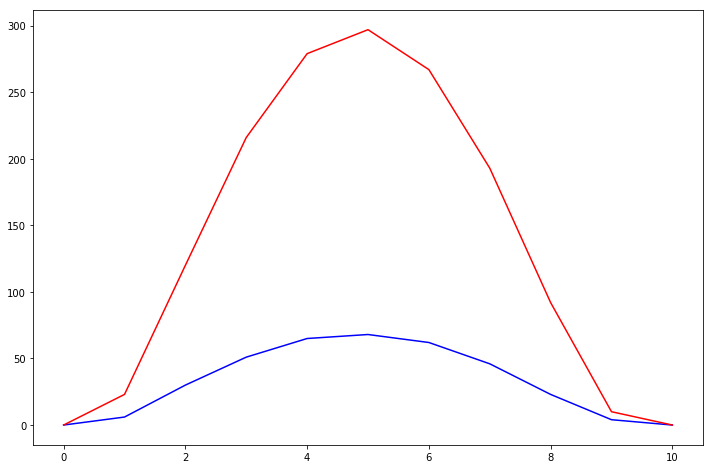

In [294]:
glo_avg = s727970_df[(s727970_df.index >= '2010-01-01') & (s727970_df.index <= '2010-01-02')]['METSTAT Glo (Wh/m^2)'].values
clear_sky = s727970_df[(s727970_df.index >= '2010-01-01') & (s727970_df.index <= '2010-01-02')]['METSTAT CSKY Glo (Wh/m^2)'].values

fig = plt.figure(figsize=(12, 8))
plt.plot(glo_avg, color='blue')
plt.plot(clear_sky, color='red')
plt.show()

## Analise de Correlação

In [295]:
pearson_correlation_coef(s727920_df.kt.tolist(),s727930_df.kt.tolist(), 24)

[0.55993557609927913,
 0.41528958564456075,
 0.35490449066860857,
 0.34297265487241174,
 0.29975433139041269,
 0.25901289435060387,
 0.22867785326411336,
 0.21631680700993772,
 0.20555787664461883,
 0.18338226077272929,
 0.21699008535595468,
 0.34123513490428148,
 0.18806533811990447,
 0.14649525552770792,
 0.13568834535531868,
 0.11948582549172079,
 0.11270346288063801,
 0.10278156423768806,
 0.097956806621474268,
 0.099530448253860759,
 0.093017285985741785,
 0.13728544435375578,
 0.27222304726255814,
 0.12453614099018546]

# Forecasting

### Preparação de treinamento e testes
A estação 727930 foi escolhida como alvo primário da predição por ser mais central e, portanto ter mais estações correlacionadas

In [296]:
target_df = s727930_df
sec1_df = s727810_df
sec2_df = s727815_df
sec3_df = s727850_df
sec4_df = s727920_df
sec5_df = s727970_df

In [297]:
target_df_train, target_df_test = split_train_test(target_df)

In [298]:
#Ajuste para remover outliers que dao erro na predicao da HOFTS

target_df_test = target_df_test.loc[target_df_test.kt <= max(target_df_train.kt)]

### High Order FTS

In [299]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts

In [300]:
train = target_df_train.kt.values

fuzzy_sets = Grid.GridPartitioner(data=train, npart=100)
model_hofts = hofts.HighOrderFTS("FTS", partitioner=fuzzy_sets)
model_hofts.fit(train, order=6)

[ 15:36:35] Start training
[ 15:36:35] Starting batch 1
[ 15:36:37] Finish batch 1
[ 15:36:37] Starting batch 2
[ 15:36:38] Finish batch 2
[ 15:36:38] Starting batch 3
[ 15:36:40] Finish batch 3
[ 15:36:40] Starting batch 4
[ 15:36:41] Finish batch 4
[ 15:36:41] Starting batch 5
[ 15:36:43] Finish batch 5
[ 15:36:43] Starting batch 6
[ 15:36:45] Finish batch 6
[ 15:36:45] Starting batch 7
[ 15:36:46] Finish batch 7
[ 15:36:46] Starting batch 8
[ 15:36:48] Finish batch 8
[ 15:36:48] Starting batch 9
[ 15:36:50] Finish batch 9
[ 15:36:50] Starting batch 10
[ 15:36:51] Finish batch 10
[ 15:36:51] Starting batch 11
[ 15:36:51] Finish batch 11
[ 15:36:51] Finish training


In [301]:
forecast_hofts = model_hofts.predict(target_df_test.kt.values)

In [302]:
forecasted_final = [x * y for x, y in zip(forecast_hofts, target_df_test['METSTAT CSKY Glo (Wh/m^2)'].tolist()[5:])]

In [303]:
_nrmse = normalized_rmse(target_df_test['METSTAT Glo (Wh/m^2)'].tolist()[5:], forecasted_final)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  14.8182861106 



### ANN

Preparação de dataset

In [314]:
from sklearn.neural_network import MLPRegressor

In [318]:
df = target_df_train
nlags = 6
X = []
vals = df.kt.tolist()
for i in np.arange(len(df)-nlags):
    row = vals[i:(i+nlags)]
    X.append(row)

Y = vals[nlags:] 

In [322]:
df = target_df_test
nlags = 6
X_test = []
vals = df.kt.tolist()
for i in np.arange(len(df)-nlags):
    row = vals[i:(i+nlags)]
    X_test.append(row)

Y_test = vals[nlags:] 

In [316]:
ann_model = MLPRegressor(hidden_layer_sizes=(6,),
                            activation='logistic',
                            solver='sgd',
                            learning_rate='adaptive',
                            max_iter=1000,
                            learning_rate_init=0.01,
                            alpha=0.0001)

In [319]:
ann_model.fit(X, Y)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [323]:
pred1 = ann_model.predict(X_test)

In [324]:
_nrmse = normalized_rmse(target_df_test['kt'].tolist()[nlags:], pred1)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  43.7273260426 

